<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/cv/faces-mlcon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognition with OpenCV and TensorFlow

## MLCon, Berlin, December 2022

https://mlconference.ai/machine-learning-advanced-development/image-recognition-with-opencv-and-tensorflow/

Tim Wüllner, OPEN KNOWLEDGE GmbH
<br>
tim.wuellner@openknowledge.de
<br>
https://www.linkedin.com/in/tim-w%C3%BCllner-0a12111a3/
<br>
<br>
Oliver Zeigermann, OPEN KNOWLEDGE GmbH
<br>
oliver.zeigermann@openknowledge.de
<br>
https://twitter.com/DJCordhose

## Get prepared
1. Make sure you are connected to Wifi
1. Open this colab notebook: http://bit.ly/mlcon-2022-cv
1. Make sure you are logged in with your Google account (if you do not have one, just create one now)
1. Make a copy of this notebook in your Drive (this is the only notebook you will work in today)

## Outline

Duration: 3 hrs 30 min, 30 minute break, 180 min total

### Part I
1. Overview (10 mins)
   * Mode: we go through the notebook together
   * There are a number of experiments
   * Questions, Doubts, Concerns are welcome *at any time*
   * This is not school
1. Challenge (10 mins)
1. Use Deep Learning (TensorFlow) (60 mins)

### Break 30 min

### Part II
1. Add preprocessing (OpenCV) (45 mins)
1. Trying things in the real world (out-of-sample evaluation) (45 mins)
1. Wrap-up (going through all steps again) (10 mins) 

## Optional Parts
1. Fine-Tuning with curated dataset
1. Beyond CNNs

## More ideas
1. Add weights to compensate for imbalanced data set: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
1. Add augmentation
   * the classic stuff: https://keras.io/keras_cv/
   * use images preprocessed by OpenCV
1. Train on individual features, rather than complex emotion
   * features are multi-hot instead of one-hot (binary loss intead of categorical)
   * features may include
     * form of mouth, e.g. open, cornes up/down
     * teeth, e.g. visible
     * eyes, e.g. narrow, wide open, relaxed
     * tilt of head
     * etc.
   * requires more domain knowledge
   * allows using all images including disgust and fear
   * makes model more universal, extensible without retraining
1. Upsample resolution of training data
   * allows for usage of high res images in fine tuning and prediction
   * might even allow to use net pretrained on ImageNet


## Resources
* https://github.com/ageron/handson-ml3
  * https://github.com/ageron/handson-ml3/blob/main/14_deep_computer_vision_with_cnns.ipynb
* https://github.com/fchollet/deep-learning-with-python-notebooks
* https://twitter.com/Jeande_d/status/1588961013704990720
  * https://cs231n.github.io/
  * https://web.stanford.edu/class/cs231a/course_notes.html





# Challenge for today: Detecting emotions from facial expressions

<img src='https://raw.githubusercontent.com/DJCordhose/ml-resources/main/img/ai_at_work.jpeg'>

<img src='https://djcordhose.github.io/ml-resources/img/emotions.png'>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [2]:
import numpy as np
np.__version__

'1.21.6'

In [3]:
import pandas as pd
pd.__version__

'1.3.5'

# Part I: Train a Model

## Getting and preprocessing faces data

* https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
* https://www.kaggle.com/datasets/msambare/fer2013
* https://blog.devgenius.io/facial-expression-recognition-with-tensorflow-90f6174163c3
  * https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

In [4]:
!wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/fer2013.tar.gz

--2022-11-26 11:22:49--  https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/fer2013.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/fer2013.tar.gz [following]
--2022-11-26 11:22:49--  https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/fer2013.tar.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
!tar -xzvf fer2013.tar.gz

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [6]:
FER2013_CSV_PATH = "./fer2013/fer2013.csv"

In [7]:
df = pd.read_csv(FER2013_CSV_PATH)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
label_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [9]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [10]:
def plot_data(data, classes):
  
  values = data["emotion"].value_counts().sort_index(ascending=True)

  plt.bar(x=classes, height=values, edgecolor='black')

  plt.xlabel("Emotions")
  plt.ylabel("Amount")
  plt.title("Amount of emotions")
  plt.show();

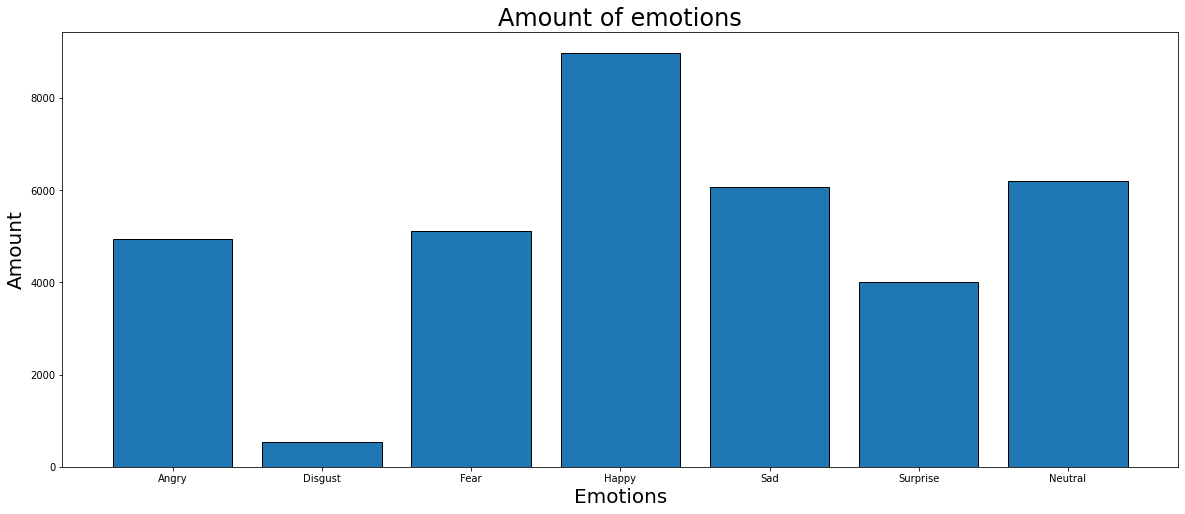

In [11]:
plot_data(df, label_names)

taking advice from 

https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

we leave out fear and disgust because they are hard to produce, plus disgust has few samples only

In [12]:
filtered_df = df[df["emotion"].isin([0, 3, 4, 5, 6, 7])]

In [13]:
# now some labels just don't have a samples, we shift all lables to the left

filtered_df["emotion"].value_counts()

3    8989
6    6198
4    6077
0    4953
5    4002
Name: emotion, dtype: int64

In [14]:
filtered_label_names = ["Angry", "Happy", "Sad", "Surprise", "Neutral"]

In [15]:
# pandas again makes this impossible to get right without stack overflow
# this does work even though we can an error
filtered_df.loc[filtered_df["emotion"] == 3, "emotion"] = 1
filtered_df.loc[filtered_df["emotion"] == 4, "emotion"] = 2
filtered_df.loc[filtered_df["emotion"] == 5, "emotion"] = 3
filtered_df.loc[filtered_df["emotion"] == 6, "emotion"] = 4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
filtered_df["emotion"].value_counts()

1    8989
4    6198
2    6077
0    4953
3    4002
Name: emotion, dtype: int64

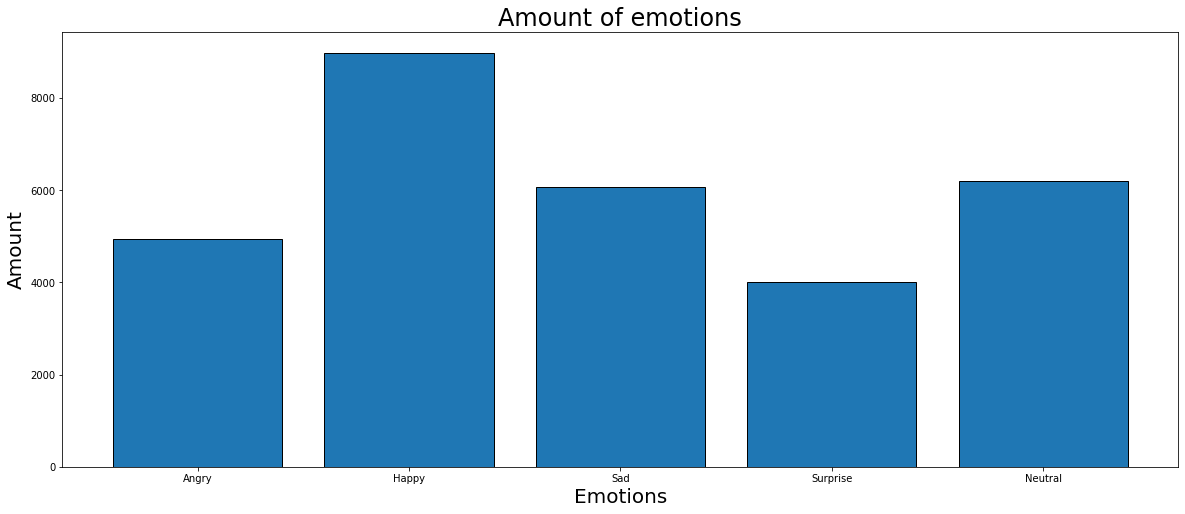

In [17]:
plot_data(filtered_df, filtered_label_names)

In [18]:
df = filtered_df

In [19]:
pixels = df["pixels"]
len(pixels)

30219

In [20]:
resolution = (48, 48)
def image_from_pixels(pixels):
    image = np.reshape(np.array(pixels.split(), 'uint8'), resolution)
    return image

In [21]:
%%time

images = np.array([image_from_pixels(p) for p in pixels])
images.shape, images.dtype

CPU times: user 8.86 s, sys: 363 ms, total: 9.22 s
Wall time: 10.6 s


((30219, 48, 48), dtype('uint8'))

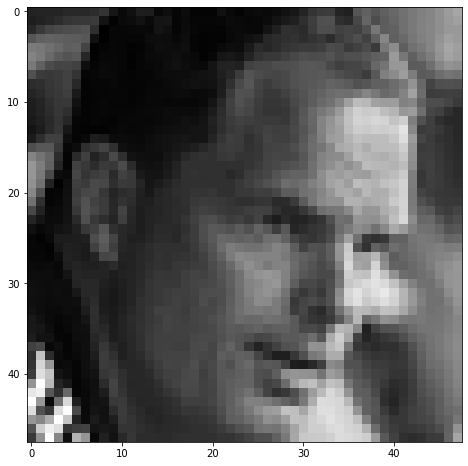

In [22]:
plt.imshow(images[100], cmap='gray');

In [23]:
labels = df["emotion"].values

In [24]:
labels.shape

(30219,)

In [25]:
def plot_gallery(X, y, label_names, size=15):

    population = X.shape[0]
    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image, cmap='gray')
        y_true = y[i]
        plt.title(label_names[y_true])
        plt.axis("off")

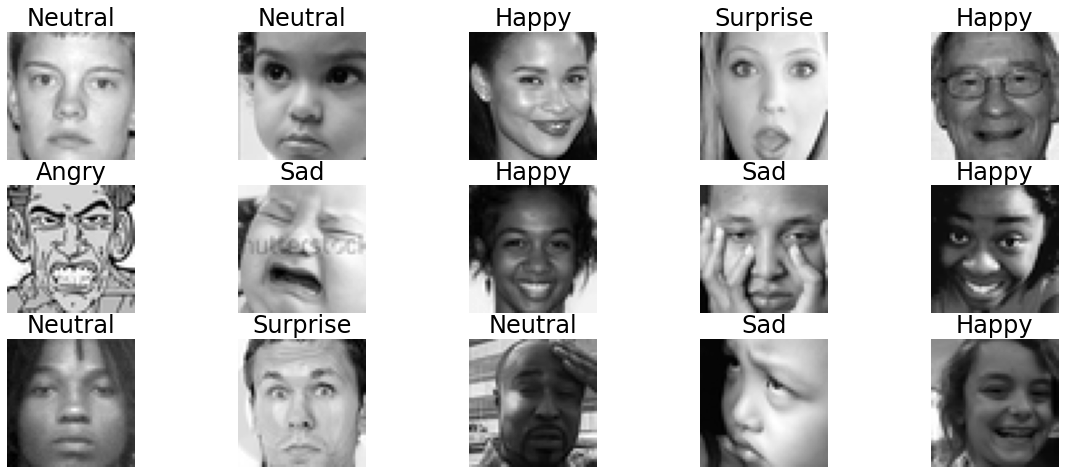

In [26]:
plot_gallery(images, labels, filtered_label_names)

## Preparing Training (Tim)

In [27]:
images.shape, images.dtype

((30219, 48, 48), dtype('uint8'))

In [28]:
# images encoded as 0..255 bit maps
# neural networks can deal with bytes, but like floats close to 0 better
images.max(), images.min()

(255, 0)

In [29]:
# sometimes numpy is just great: broadcast
images_normlized = images / 255.0

# we also need to expand images, as the prebuild networks expect that
images_normlized = np.expand_dims(images_normlized, axis=-1)

In [30]:
images_normlized.shape, images_normlized.dtype, images_normlized.max(), images_normlized.min()

((30219, 48, 48, 1), dtype('float64'), 1.0, 0.0)

In [31]:
X = images_normlized
y = labels

In [32]:
np.unique(labels)

array([0, 1, 2, 3, 4])

In [33]:
num_classes = labels.max() + 1
num_classes

5

In [34]:
input_shape=(48, 48, 1)

## Excursion I: Deep Learning - Slides

## What kind of model should we use?

* Coming up with a decent CNN architecture is a research topic
* Using a prebuilt architecture often is the best choice
  * https://keras.io/api/applications/
  * having a lot of good training data, can make additional regularization unnecessary
  * it can be done, though, but not trivially: https://sthalles.github.io/keras-regularizer/
* however, accuracy is not the only metric we are concerned about
  * we also need this to be portable to run in the browser in the first place, plus
  * we need this to react in near real time to be useable
  * training any default architecture on CPU is simply not feasible
  * do we have a GPU availble for training 
  * which one, how powerful?
  * even on GPU this can take quite some time

In [35]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [36]:
!nvidia-smi

Sat Nov 26 11:23:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Custom Model

In [38]:
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

dropout = 0.5

model = tf.keras.Sequential(name='custom_vgg')

model.add(InputLayer(input_shape=input_shape, name='input'))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

### Standard Architecture

<img src="https://djcordhose.github.io/ml-resources/img/image-recognition/cnn-architecture-overview.jpeg">

https://towardsdatascience.com/neural-network-architectures-156e5bad51ba 
<br>
https://arxiv.org/abs/1605.07678

In [39]:
use_custom_model = True
# use_custom_model = False

In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

if not use_custom_model:
  # model = ResNet50(weights='imagenet')
  model = ResNet50(weights=None, input_shape=input_shape, classes=num_classes)

In [41]:
model.summary()

Model: "custom_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

In [42]:
# https://github.com/AndreasMadsen/python-lrcurve
import sys

if 'google.colab' in sys.modules:
  !pip install -q lrcurve

In [43]:
# we play be our own rules, we do our own split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27197, 48, 48, 1), (3022, 48, 48, 1), (27197,), (3022,))

### Training

In [44]:
if use_custom_model:
  optimizer='adam'
else:  
  # optimizer='adam'
  optimizer='sgd'
optimizer  

'adam'

In [45]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [46]:
# ReduceLROnPlateau inspired by https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau()

if use_custom_model:
  patience = 10
else:
  patience=15
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)

In [47]:
%%time

from lrcurve import KerasLearningCurve

if use_custom_model:
  BATCH_SIZE = 50
else:
  # larger batch size might lead to better regularization for resent
  # (might speed up learning on a good GPU)
  BATCH_SIZE = 50

# Resnet50 75 epochs
# - 30 min on T4
# - 18 min on A100
# - < 15 min on V100

EPOCHS = 75
# should be enough for resnet
# EPOCHS = 50

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    validation_data=(X_test, y_test),
                    # validation_split=0.1,
                    callbacks=[reduce_lr, early_stopping, KerasLearningCurve()],
                    verbose=0
                    )

CPU times: user 3min 40s, sys: 12.4 s, total: 3min 52s
Wall time: 3min 23s


## Evaluating results

In [48]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
print(f'Training accuracy: {round(train_accuracy, 2)}, Test accuracy: {round(test_accuracy, 2)}')

Training accuracy: 0.73, Test accuracy: 0.68


In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(model, X, y, file_name=None, label_names=label_names):
    y_pred = model.predict(X).argmax(axis=1)
    cm = confusion_matrix(y, y_pred)
    figure = plt.figure(figsize=(10, 10))

    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d')
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [50]:
def plot_accuracy(history, file_name=None):
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Accuracy', 'Validation Accuracy']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [51]:
def plot_loss(history, file_name=None):
    plt.figure()

    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.yscale('log')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Loss', 'Validation Loss']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

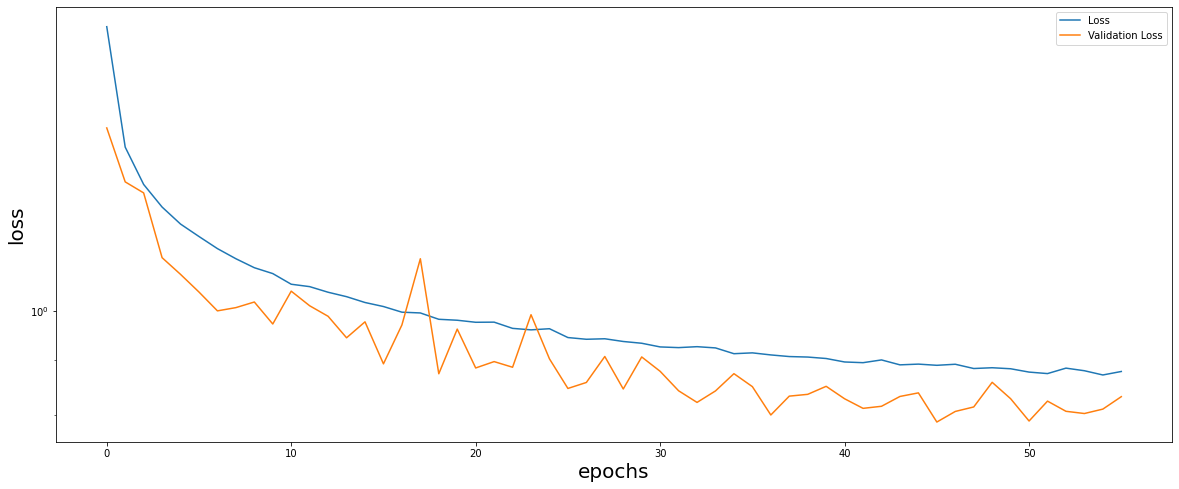

In [52]:
plot_loss(history)

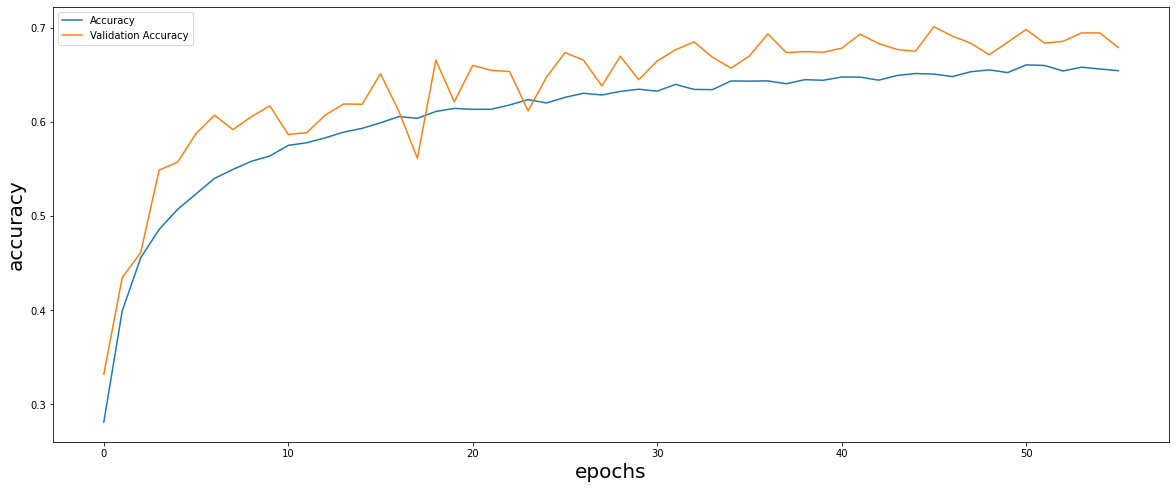

In [53]:
plot_accuracy(history)

945/945 [==============================] - 3s 2ms/step


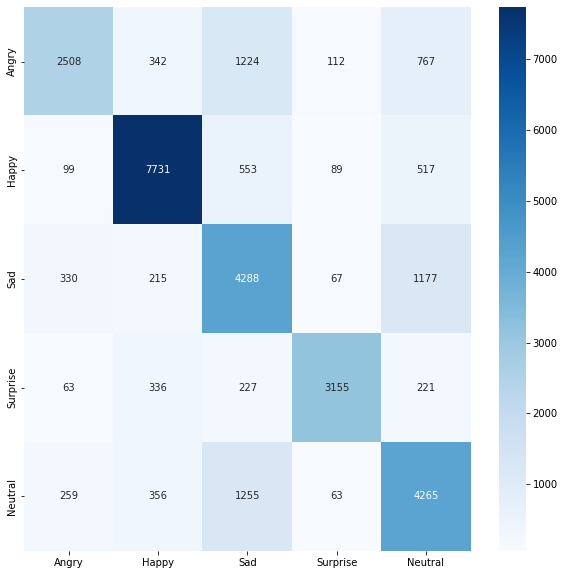

In [54]:
plot_cm(model, X, y, label_names=filtered_label_names)

850/850 [==============================] - 3s 4ms/step


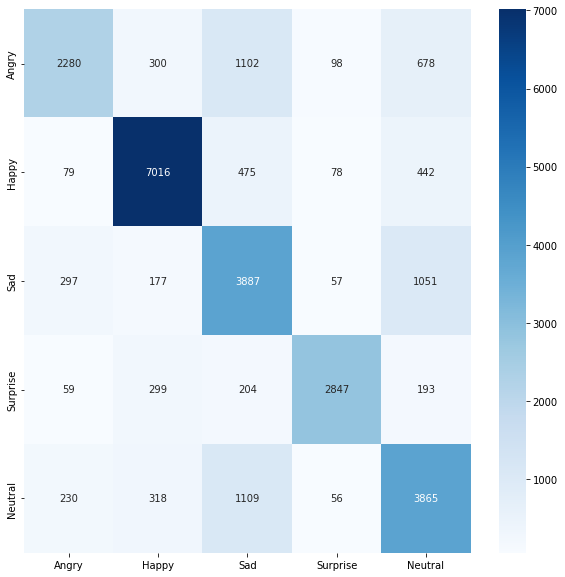

In [55]:
plot_cm(model, X_train, y_train, label_names=filtered_label_names)

95/95 [==============================] - 1s 6ms/step


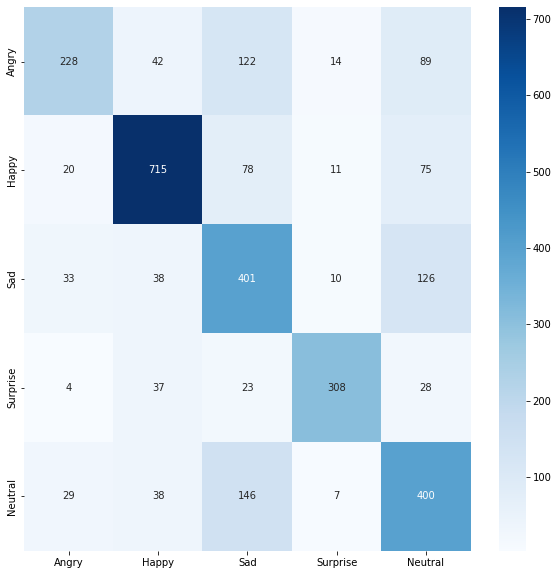

In [56]:
plot_cm(model, X_test, y_test, label_names=filtered_label_names)

## Saving model

You might also want to download it for later use

In [57]:
if use_custom_model:
  model_name = 'mlcon-simple-vgg.h5'
else:
  model_name = 'mlcon-resent50.h5'
model.save(model_name)

In [58]:
!ls -l

total 416240
drwxr-xr-x 7 root   root      4096 Nov 26 10:48 emotions
-rw-r--r-- 1 root   root  31806281 Nov 26 10:47 emotions.zip
drwxr-x--- 2 204241 5762      4096 Jul 10  2013 fer2013
-rw-r--r-- 1 root   root  96433867 Nov 26 10:34 fer2013.tar.gz
-rw-r--r-- 1 root   root   4754784 Nov 26 11:27 mlcon-simple-vgg.h5
-rw-r--r-- 1 root   root   4754784 Nov 26 10:42 odsc-simple-vgg.h5
-rw-r--r-- 1 root   root 283704376 Nov 26 11:04 resent50.h5
drwxr-xr-x 1 root   root      4096 Nov 22 00:14 sample_data
-rw-r--r-- 1 root   root   4754784 Nov 26 11:04 simple-vgg.h5


# Part II: Preprocessing (Olli)

## Challenge of our model

* Data for training comes from completely different source than for prediction
* Not uncommon
* Typically the case when having to rely on general / public dataset
* Often means test score is well below validation score
* Might need an extra round of training with small set of data from prediction source


In [59]:
!wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/emotions.zip

--2022-11-26 11:27:02--  https://github.com/DJCordhose/ml-resources/raw/main/data/emotions.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/emotions.zip [following]
--2022-11-26 11:27:02--  https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/emotions.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [60]:
!unzip -o emotions.zip

Archive:  emotions.zip
  inflating: emotions/angry/IMG-20221120-WA0013.jpg  
  inflating: emotions/angry/leonie-angry.jpg  
  inflating: emotions/angry/olli-angry.jpg  
  inflating: emotions/angry/olli-zopf-angry.jpg  
  inflating: emotions/angry/olli-zopf-brille-angry.jpg  
  inflating: emotions/angry/tim-angry.jpg  
  inflating: emotions/happy/IMG-20221120-WA0011.jpg  
  inflating: emotions/happy/leonie-happy.jpg  
  inflating: emotions/happy/olli-happy.jpg  
  inflating: emotions/happy/olli-zopf-brille-happy.jpg  
  inflating: emotions/happy/olli-zopf-happy.jpg  
  inflating: emotions/happy/tim-happy.jpg  
  inflating: emotions/neutral/IMG-20221120-WA0010.jpg  
  inflating: emotions/neutral/leonie-neutral.jpg  
  inflating: emotions/neutral/olli-neutral.jpg  
  inflating: emotions/neutral/olli-zopf-brille-neutral.jpg  
  inflating: emotions/neutral/olli-zopf-neutral.jpg  
  inflating: emotions/neutral/tim-neutral.jpg  
  inflating: emotions/sad/IMG-20221120-WA0012.jpg  
  inflating:

In [61]:
import cv2 as cv
cv.__version__

'4.6.0'

In [62]:
# Leonie
# img = cv.imread('emotions/happy/leonie-happy.jpg')
# img = cv.imread('emotions/neutral/leonie-neutral.jpg')
# img = cv.imread('emotions/sad/leonie-sad.jpg')
# img = cv.imread('emotions/surprise/leonie-surprise.jpg')
# img = cv.imread('emotions/angry/leonie-angry.jpg')

# Tim
# img = cv.imread('emotions/happy/tim-happy.jpg')
# img = cv.imread('emotions/neutral/tim-neutral.jpg')
# img = cv.imread('emotions/sad/tim-sad.jpg')
# img = cv.imread('emotions/surprise/tim-surprise.jpg')
# img = cv.imread('emotions/angry/tim-angry.jpg')

# Olli
# img = cv.imread('emotions/happy/olli-happy.jpg')
# img = cv.imread('emotions/neutral/olli-neutral.jpg')
# img = cv.imread('emotions/sad/olli-sad.jpg')
# img = cv.imread('emotions/surprise/olli-surprise.jpg')
# img = cv.imread('emotions/angry/olli-angry.jpg')

# Hanna
# img = cv.imread('emotions/sad/IMG-20221120-WA0012.jpg')
img = cv.imread('emotions/surprise/IMG-20221120-WA0014.jpg') 

img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_rgb.shape

(2048, 1153, 3)

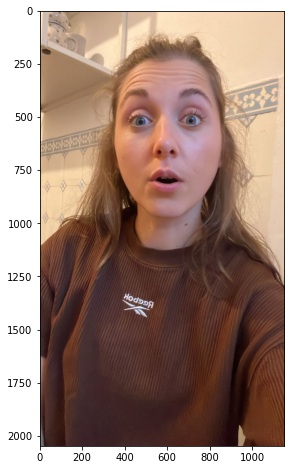

In [63]:
plt.imshow(img_rgb);

## OpenCV Processing

### Overview: Common Methods used with OpenCV

* Convolutions (Blur/Sobel/Sharpen): https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
* Edge-Detection: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
* Morphological Operations (Opening/Closing): https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
* Contours and Bounding Boxes: https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
* Segmentation: https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
* Template Matching: https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html

https://docs.opencv.org/4.x/d2/d96/tutorial_py_table_of_contents_imgproc.html


### Obvously when using in prodcution, we do not have the faces nicely cut out so far

* can be done
  * also based on ML, but ML other people have already done for us
  * requires a good set of bounding boxes as training data
  * advanced techniques like SSD (https://towardsdatascience.com/ssd-single-shot-detector-for-object-detection-using-multibox-1818603644ca) require a lot of compute to train

* Approaches
  * https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html
  * https://pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/
  * https://pyimagesearch.com/2021/04/26/face-detection-tips-suggestions-and-best-practices/
  * https://pyimagesearch.com/2022/10/24/thermal-vision-fever-detector-with-python-and-opencv-starter-project/

#### Our approach: Cascade Classifier

* OpenCV implementation available 
* error prone, but fast
* works in browser
* fast and small model
* alternatives: https://pyimagesearch.com/2021/04/26/face-detection-tips-suggestions-and-best-practices/

https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html



### Grayscale

needed by facial extraction

((2048, 1153), 254)

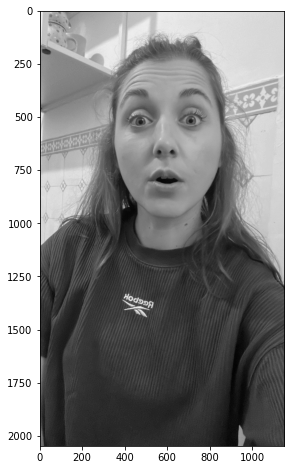

In [64]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')
img_gray.shape, img_gray.max()

### Histogram Equalization (might make it easier for face extraction)

normalizes the brightness and increases the contrast of the image

* flattens the gray-level histogram 
* all intensities are as equally common as possible

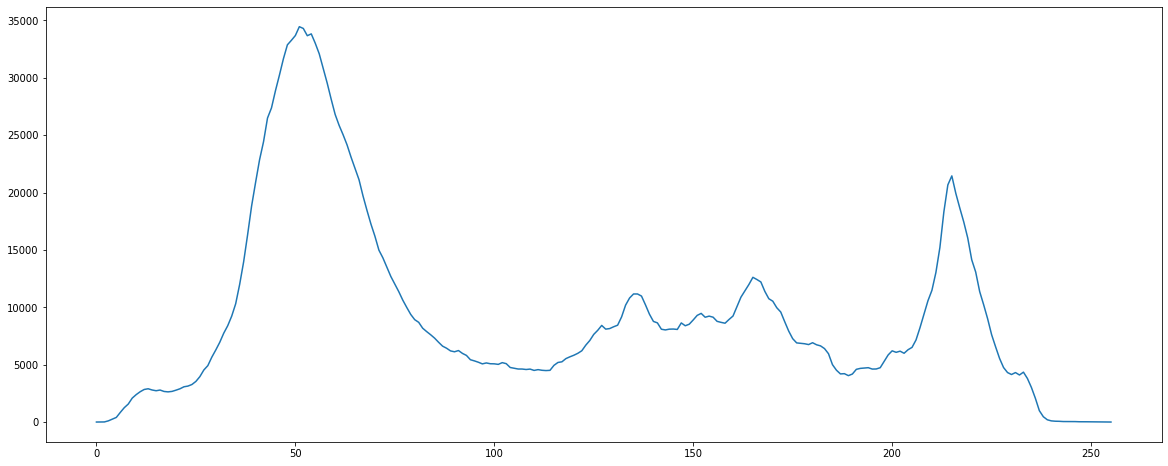

In [65]:
histr = cv.calcHist([img_gray],[0],None,[256],[0,256])
plt.plot(histr);

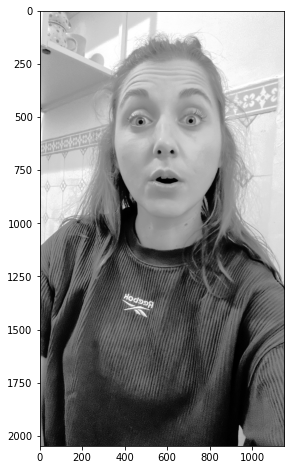

In [66]:
img_gray = cv.equalizeHist(img_gray)
plt.imshow(img_gray, cmap='gray');

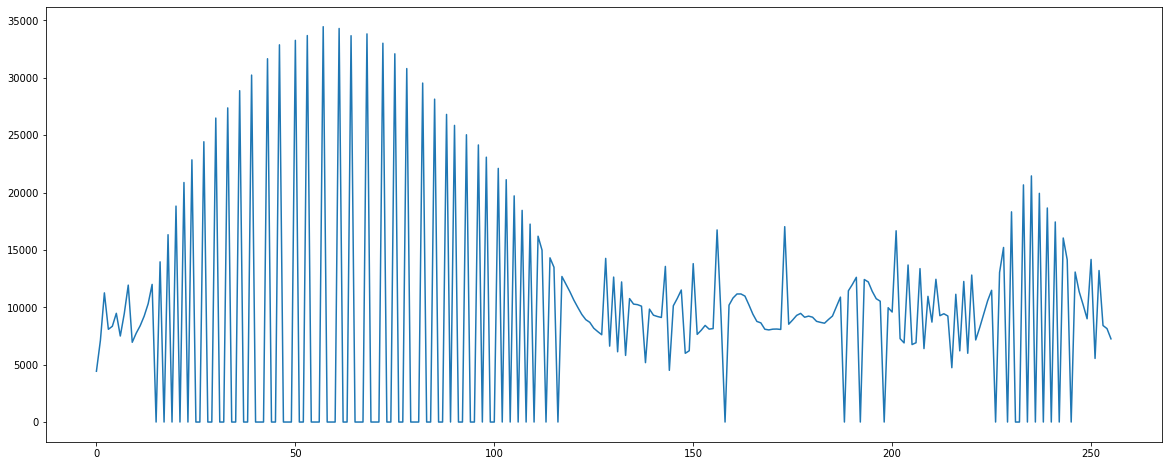

In [67]:
histr = cv.calcHist([img_gray],[0],None,[256],[0,256])
plt.plot(histr);

### Extraction of Region Of Interest (ROI)

In [68]:
img_height, img_width = img_gray.shape
img_height, img_width

(2048, 1153)

In [69]:
min_face_height = round(img_height * .1)
min_face_width = round(img_width * .1)
min_face_height, min_face_width

(205, 115)

In [70]:
faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        img_gray,
        minSize=(min_face_height, min_face_width)
) 
faces

array([[218, 222, 733, 733]], dtype=int32)

In [71]:
# we assume a single face
largest_index = faces[:, 3].argmax()
face = faces[largest_index]
fx, fy, fw, fh = face
face

array([218, 222, 733, 733], dtype=int32)

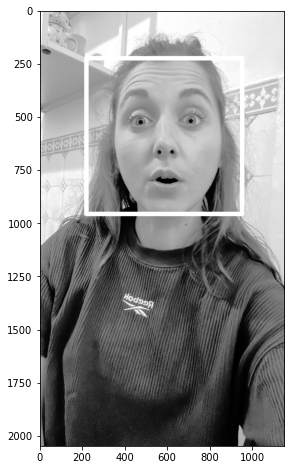

In [72]:
color = (255, 0, 255)
thickness = 20

frame_gray = img_gray.copy()

center = (fx + fw//2, fy + fh//2)
# frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, color, thickness)
pt1 = (fx, fy)
pt2 = (fx + fw, fy + fh)
cv.rectangle(frame_gray, pt1, pt2, color, thickness)
plt.imshow(frame_gray, cmap='gray');    

(733, 733)

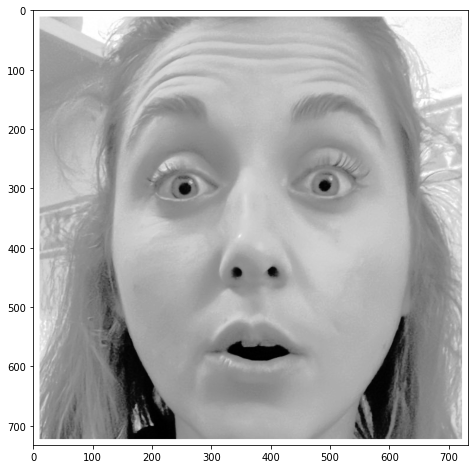

In [73]:
roi = frame_gray[fy:fy+fh,fx:fx+fw]
plt.imshow(roi, cmap='gray');
roi.shape

### Resizing and normalizing

In [74]:
roi = cv.resize(roi, (48, 48), 0, 0, cv.INTER_AREA);
# roi = cv.normalize(roi, 0, 1.0, cv.NORM_MINMAX);
roi = roi / 255.0

((48, 48), 0.0, 1.0)

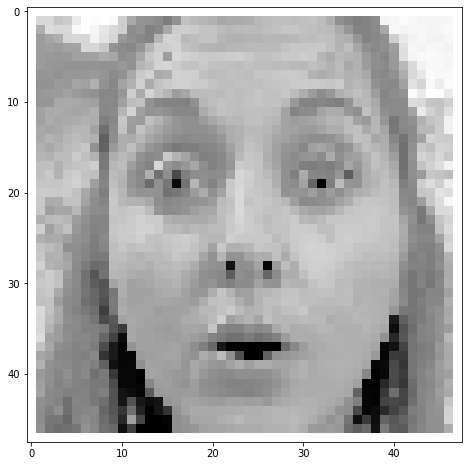

In [75]:
plt.imshow(roi, cmap='gray');
roi.shape, roi.min(), roi.max()

## Lowres image looks horrible, maybe we can do something about it

### Convolutions

An old friend: https://setosa.io/ev/image-kernels/

https://en.wikipedia.org/wiki/Kernel_(image_processing)
<br>
https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

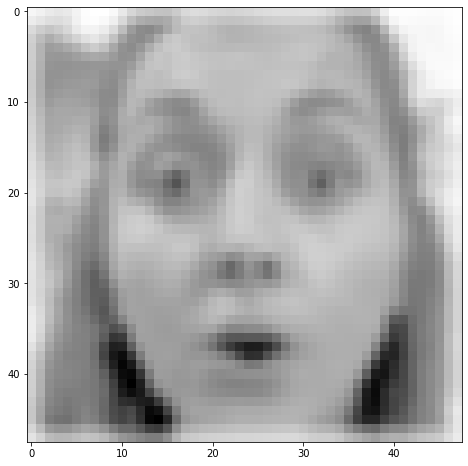

In [76]:
blur = cv.GaussianBlur(roi, (3,3), 0)
plt.imshow(blur, cmap='gray');

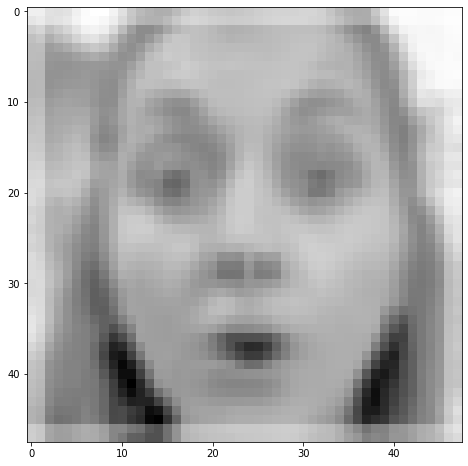

In [77]:
ksize = 3
kernel = np.ones((ksize, ksize),np.float32)/(ksize * ksize)
averaged = cv.filter2D(roi,-1,kernel)
plt.imshow(averaged, cmap='gray');

In [78]:
kernel

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]], dtype=float32)

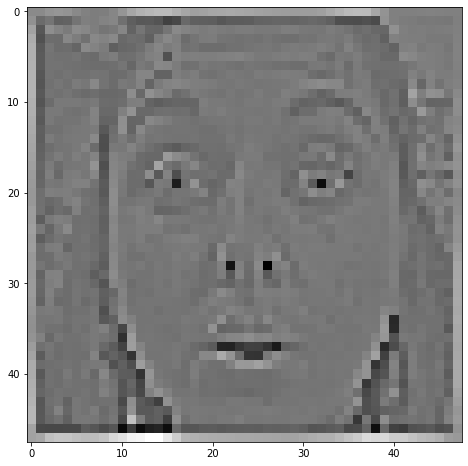

In [79]:
# high pass

# kernel = np.array([
#     [0, -1, 0],
#     [-1, 5, -1],
#     [0, -1, 0],
# ],np.float32)

# actually a laplacian filter, nhances the edges, corners even more
kernel = np.array([
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1],
],np.float32)

high_pass = cv.filter2D(roi, -1, kernel)
high_pass = (high_pass - high_pass.min()) / (high_pass.max() + abs(high_pass.min()))
plt.imshow(high_pass, cmap='gray');

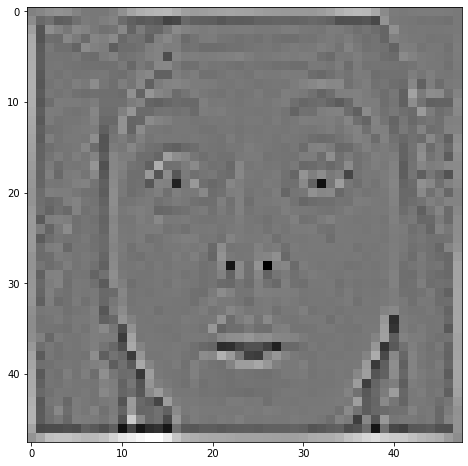

In [80]:
# an old trick, remove the blur from original
sharpened = roi - blur
sharpened = (sharpened - sharpened.min()) / (sharpened.max() + abs(sharpened.min()))

plt.imshow(sharpened, cmap='gray');

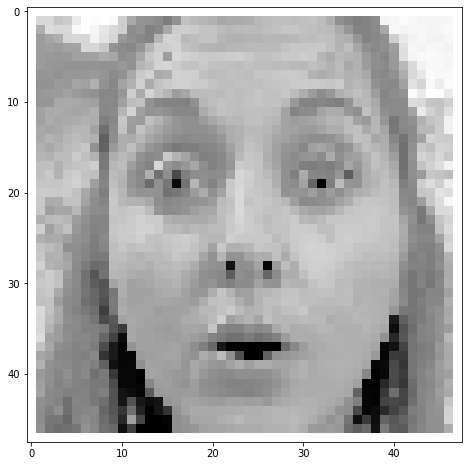

In [81]:
plt.imshow(roi, cmap='gray');

### Morphological Transformations
* works best on b/w images
* also works on grayscale, but
  * white or bright spots are supposed to be the information
  * black or dark is background

https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

In [82]:
# just a structure used by the transformations
kernel = np.ones((2,2),np.uint8)

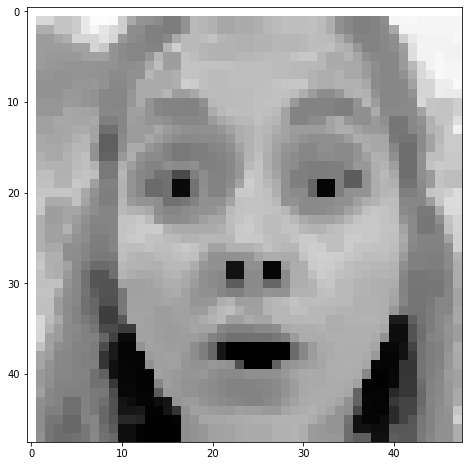

In [83]:
# erosion
erosion = cv.erode(roi, kernel, iterations = 1)
plt.imshow(erosion, cmap='gray');

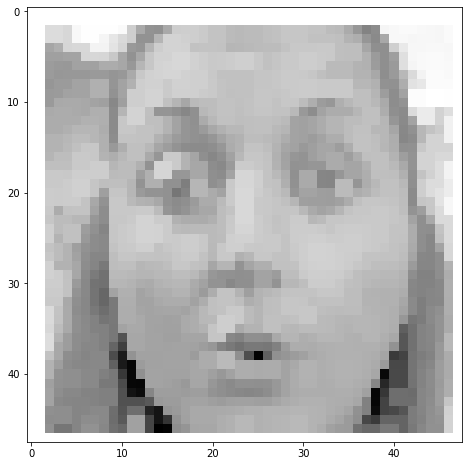

In [84]:
# dilation
dilation = cv.dilate(roi, kernel, iterations = 1)
plt.imshow(dilation, cmap='gray');

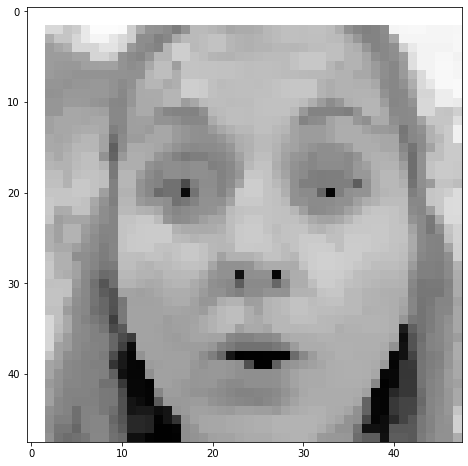

In [85]:
# opening (removes noise)
opening = cv.morphologyEx(roi, cv.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray');

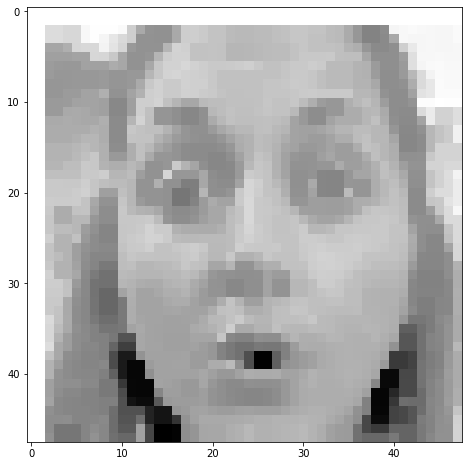

In [86]:
# closing (fills holes)
closing = cv.morphologyEx(roi, cv.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray');

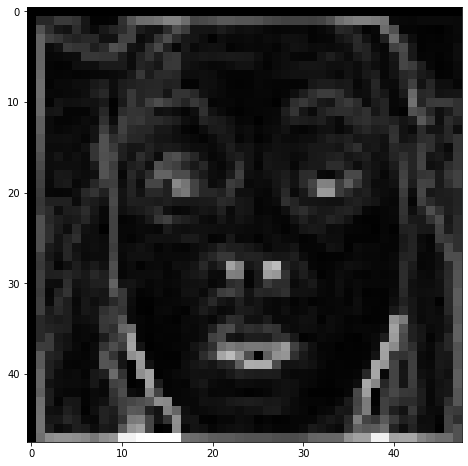

In [87]:
# gradient: difference between dilation and erosion of an image
gradient = cv.morphologyEx(roi, cv.MORPH_GRADIENT, kernel)
plt.imshow(gradient, cmap='gray');

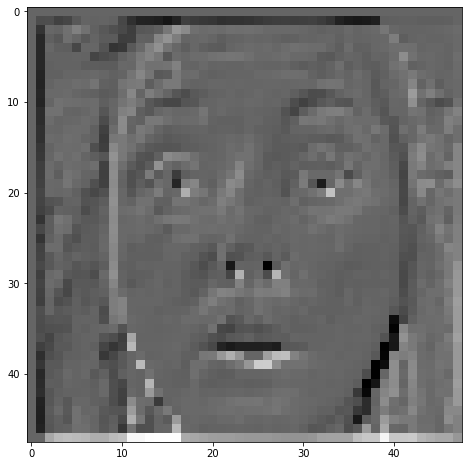

In [88]:
# tophat: difference between input image and opening
tophat = cv.morphologyEx(roi, cv.MORPH_TOPHAT, kernel)
plt.imshow(tophat, cmap='gray');

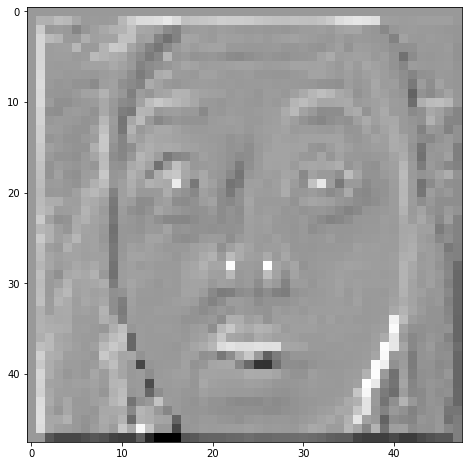

In [89]:
# blackhat: difference between input image and closing
blackhat = cv.morphologyEx(roi, cv.MORPH_BLACKHAT, kernel)
plt.imshow(blackhat, cmap='gray');

### FFT

* The Most Important Algorithm Of All Time: https://youtu.be/nmgFG7PUHfo
* code adapted from: https://colab.research.google.com/github/xn2333/OpenCV/blob/master/Image_Processing_in_Python_Final.ipynb#scrollTo=wD_RR9rBfLS5

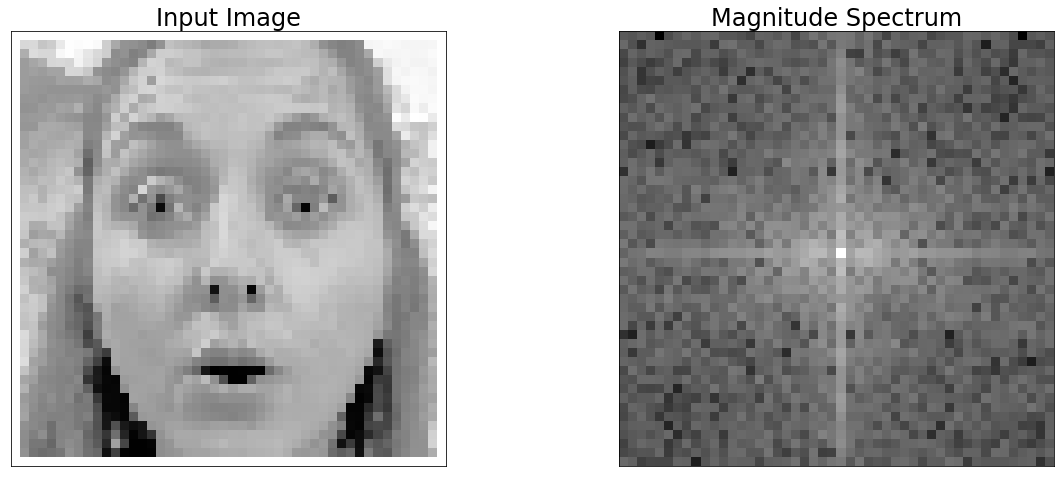

In [90]:
f = np.fft.fft2(roi)
# Bring the zero-frequency component to the center
fshift = np.fft.fftshift(f)
magnitude_spectrum = 30*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(roi, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


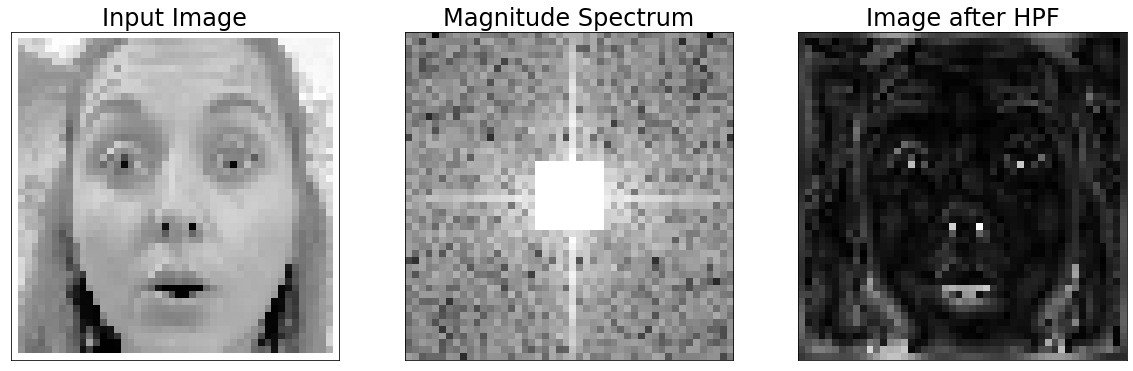

In [91]:
rows, cols = blur.shape
crow, ccol = round(rows/2) , round(cols/2)

f = np.fft.fft2(roi)
fshift = np.fft.fftshift(f)

# remove low frequencies
# cutoff = 15
# cutoff = 10
cutoff = 5
fshift[crow-cutoff:crow+cutoff, ccol-cutoff:ccol+cutoff] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

magnitude_spectrum = 30*np.log(np.abs(fshift))

plt.figure(figsize=([20, 20]))
plt.subplot(131),plt.imshow(roi, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.show();
ffp_highpass = img_back

### Choose your weapon

you could also choose a combination if you know what you are doing


(0.0, 1.0, dtype('float64'))

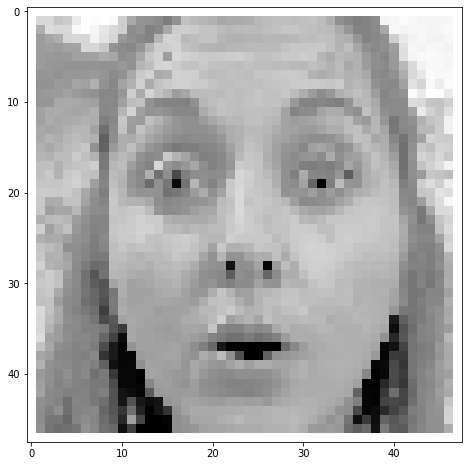

In [92]:
# do nothing
test_img = roi # maybe even the most promising 

# simple convolution
# test_img = blur  # promising
# test_img = averaged # promising
# test_img = high_pass  # promising
# test_img = sharpened # promising

# morphological transformation
# test_img = erosion  # promising
# test_img = dilation
# test_img = opening # promising
# test_img = closing

# might only make sense when combined with inversion
# test_img = gradient
# test_img = tophat
# test_img = blackhat

# test_img = ffp_highpass

# normalization (might not be necessary for most transformations, but just to make sure)
test_img = (test_img - test_img.min()) / (test_img.max() + abs(test_img.min()))

# potential inverse step
# test_img = test_img.max() - test_img

plt.imshow(test_img, cmap='gray');
test_img.min(), test_img.max(), test_img.dtype

### Preparation for prediction

In [93]:
test_img = np.expand_dims(test_img, axis=-1)
test_img = np.expand_dims(test_img, axis=0)
test_img.shape

(1, 48, 48, 1)

In [94]:
# you can load a predefined model

# !wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/simple-vgg.h5
# !wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/resent50.h5

In [95]:
import tensorflow as tf
# model = tf.keras.models.load_model('simple-vgg.h5')
# model = tf.keras.models.load_model('resent50.h5')

In [96]:
filtered_label_names = ["Angry", "Happy", "Sad", "Surprise", "Neutral"]

In [97]:
y_pred_probas = model.predict(test_img)
clazz = y_pred_probas.argmax()
proba = y_pred_probas.max()
filtered_label_names[clazz], proba, y_pred_probas

1/1 [==============================] - 0s 68ms/step


('Surprise',
 0.9935969,
 array([[0.0017767 , 0.00218021, 0.00126699, 0.9935969 , 0.00117913]],
       dtype=float32))

# Part III: Integration, ML as a system (Tim)

## Complete pipeline

In [98]:
def preprocess(path):
  img = cv.imread(path)
  img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img_gray = cv.equalizeHist(img_gray)
  # add whatever processing you have here

  face = detect_face(img_gray)
  if face is None:
    return None
  x, y, w, h = face
  frame_gray = img_gray.copy()
  roi = frame_gray[y:y+h,x:x+w]
  roi = cv.resize(roi, (48, 48), 0, 0, cv.INTER_AREA);
  # roi = cv.normalize(roi, 0, 1.0, cv.NORM_MINMAX);
  roi = roi / 255.0
  test_img = np.expand_dims(roi, axis=-1)
  # test_img = np.expand_dims(test_img, axis=0)
  return test_img

def detect_face(img_gray):
  img_height, img_width = img_gray.shape
  min_face_height = round(img_height * .1)
  min_face_width = round(img_width * .1)
  faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
  faces = faceCascade.detectMultiScale(
          img_gray,
          minSize=(min_face_height, min_face_width)
  ) 
  if faces is None:
    return None

  # we assume a single face
  largest_index = faces[:, 3].argmax()
  face = faces[largest_index]
  return face

def predict(test_img):
  y_pred_probas = model.predict(test_img)
  clazz = y_pred_probas.argmax()
  proba = y_pred_probas.max()
  return filtered_label_names[clazz], proba, y_pred_probas

(48, 48, 1)

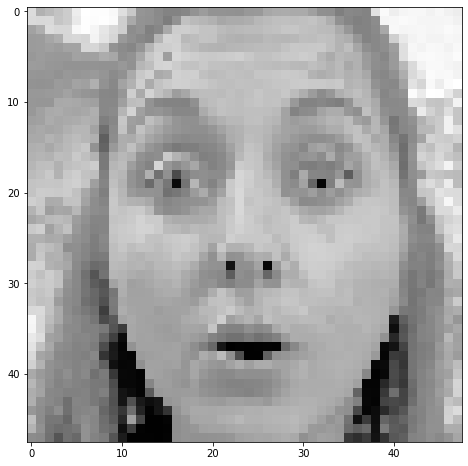

In [99]:
img = preprocess('emotions/surprise/IMG-20221120-WA0014.jpg')
plt.imshow(img.reshape(48, 48), cmap='gray');
img.shape

In [100]:
predict(np.expand_dims(img, axis=0))

1/1 [==============================] - 0s 18ms/step


('Surprise',
 0.9935822,
 array([[0.00190235, 0.00208373, 0.00126393, 0.9935822 , 0.00116774]],
       dtype=float32))

## Evaluation on real world data

In [101]:
!ls -lR emotions

emotions:
total 20
drwxr-xr-x 2 root root 4096 Nov 26 11:27 angry
drwxr-xr-x 2 root root 4096 Nov 26 11:27 happy
drwxr-xr-x 2 root root 4096 Nov 26 11:27 neutral
drwxr-xr-x 2 root root 4096 Nov 26 11:27 sad
drwxr-xr-x 2 root root 4096 Nov 26 11:27 surprise

emotions/angry:
total 6336
-rw-r--r-- 1 root root  264780 Nov 21 15:45 IMG-20221120-WA0013.jpg
-rw-r--r-- 1 root root  173760 Oct 28 17:02 leonie-angry.jpg
-rw-r--r-- 1 root root 2139114 Oct 28 17:06 olli-angry.jpg
-rw-r--r-- 1 root root 1859338 Nov 18 11:05 olli-zopf-angry.jpg
-rw-r--r-- 1 root root 1846678 Nov 18 11:05 olli-zopf-brille-angry.jpg
-rw-r--r-- 1 root root  194744 Oct 28 16:53 tim-angry.jpg

emotions/happy:
total 6244
-rw-r--r-- 1 root root  284105 Nov 21 15:45 IMG-20221120-WA0011.jpg
-rw-r--r-- 1 root root  190881 Oct 28 17:03 leonie-happy.jpg
-rw-r--r-- 1 root root 1913455 Oct 28 17:06 olli-happy.jpg
-rw-r--r-- 1 root root 1886990 Nov 18 11:05 olli-zopf-brille-happy.jpg
-rw-r--r-- 1 root root 1917482 Nov 18 11:05 oll

In [102]:
%%time 

import os
data_dir = 'emotions'
type = ".jpg"

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d))]
# Loop through the label directories and collect the data in
# two lists, labels and images.
labels = []
images = []
for d in directories:
    label_dir = os.path.join(data_dir, d)
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for f in file_names:
      img = preprocess(f)
      images.append(img)
      label = filtered_label_names.index(d.title())
      labels.append(label)

images, labels = np.array(images), np.array(labels)

CPU times: user 6.55 s, sys: 96.2 ms, total: 6.65 s
Wall time: 5.12 s


In [103]:
images.shape, labels

((30, 48, 48, 1),
 array([3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2,
        2, 2, 1, 1, 1, 1, 1, 1]))

In [104]:
X_real_world = images
y_real_world = labels

### Current Model

In [105]:
local_model = model

In [106]:
model.name

'custom_vgg'

In [107]:
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, verbose=0)
real_world_accuracy

0.6666666865348816

1/1 [==============================] - 0s 15ms/step


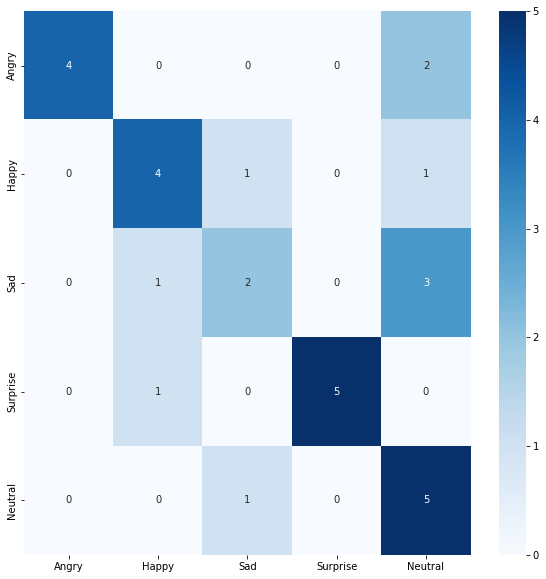

In [108]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names);

### Custom VGG

In [109]:
# you can load a predefined model

!curl -O https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/resent50.h5
!curl -O https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/simple-vgg.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  270M  100  270M    0     0  14.7M      0  0:00:18  0:00:18 --:--:-- 64.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4643k  100 4643k    0     0  3087k      0  0:00:01  0:00:01 --:--:-- 3085k


In [110]:
import tensorflow as tf
model = tf.keras.models.load_model('simple-vgg.h5')
# model = tf.keras.models.load_model('resent50.h5')
simple_vgg_model = model

In [111]:
model.name

'custom_vgg'

In [112]:
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, verbose=0)
real_world_accuracy

0.7666666507720947

1/1 [==============================] - 0s 121ms/step


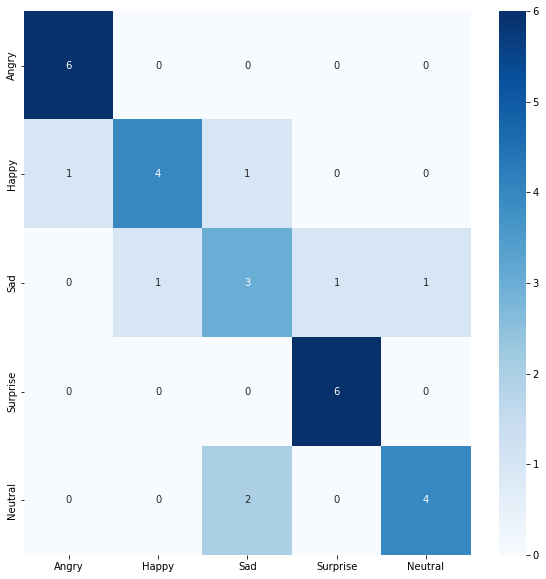

In [113]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names);

### Resnet 50

In [114]:
import tensorflow as tf
# model = tf.keras.models.load_model('simple-vgg.h5')
model = tf.keras.models.load_model('resent50.h5')
resent50_model = model

In [115]:
model.name

'resnet50'

In [116]:
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, verbose=0)
real_world_accuracy

0.6000000238418579

1/1 [==============================] - 1s 806ms/step


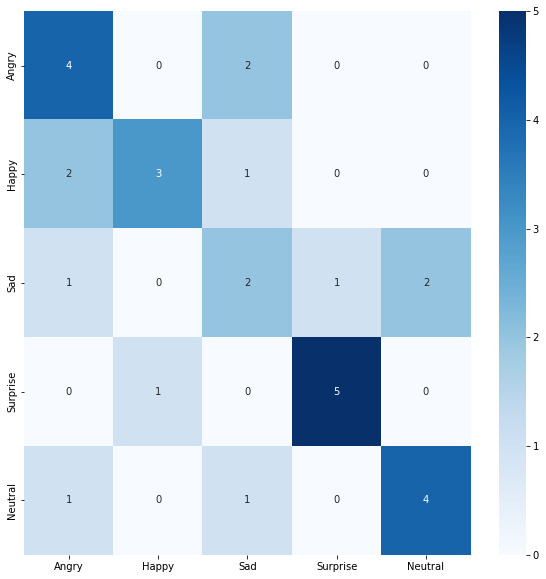

In [117]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names);

## Looking at subclasses

In [118]:
def plot_gallery(model, X, y, label_names, size=15):
    figure = plt.figure(figsize=(40, 20))

    y_pred_raw = model.predict(X, verbose=0)
    certainty = y_pred_raw.max(axis=1)
    y_pred = y_pred_raw.argmax(axis=1)
    population = X.shape[0]

    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image.reshape(48, 48), cmap='gray')
        y_true = y[i]
        y_pred = model.predict(tf.expand_dims(image, 0), verbose=0).argmax(axis=1)[0]
        plt.title("{} (was {}): {} ({:3d}%)".format(label_names[y_pred],
                                                  label_names[y_true],
                                                  i,
                                                  int(certainty[i] * 100)),
                  color=("green" if y_pred == y_true else "red"))
        plt.axis("off")
    return certainty.max(), certainty.min(), certainty.mean()

In [119]:
# which model do we want?

model = local_model
# model = resent50_model
# model = simple_vgg_model
model.name

'custom_vgg'

In [120]:
y_real_world_pred_raw = model.predict(X_real_world, verbose=0)
y_real_world_pred = y_real_world_pred_raw.argmax(axis=1)
y_real_world_pred

array([3, 3, 3, 1, 3, 3, 0, 4, 4, 0, 0, 0, 4, 4, 4, 4, 4, 2, 2, 4, 4, 1,
       4, 2, 4, 1, 1, 1, 2, 1])

### All

(0.99529415, 0.31414115, 0.6463061)

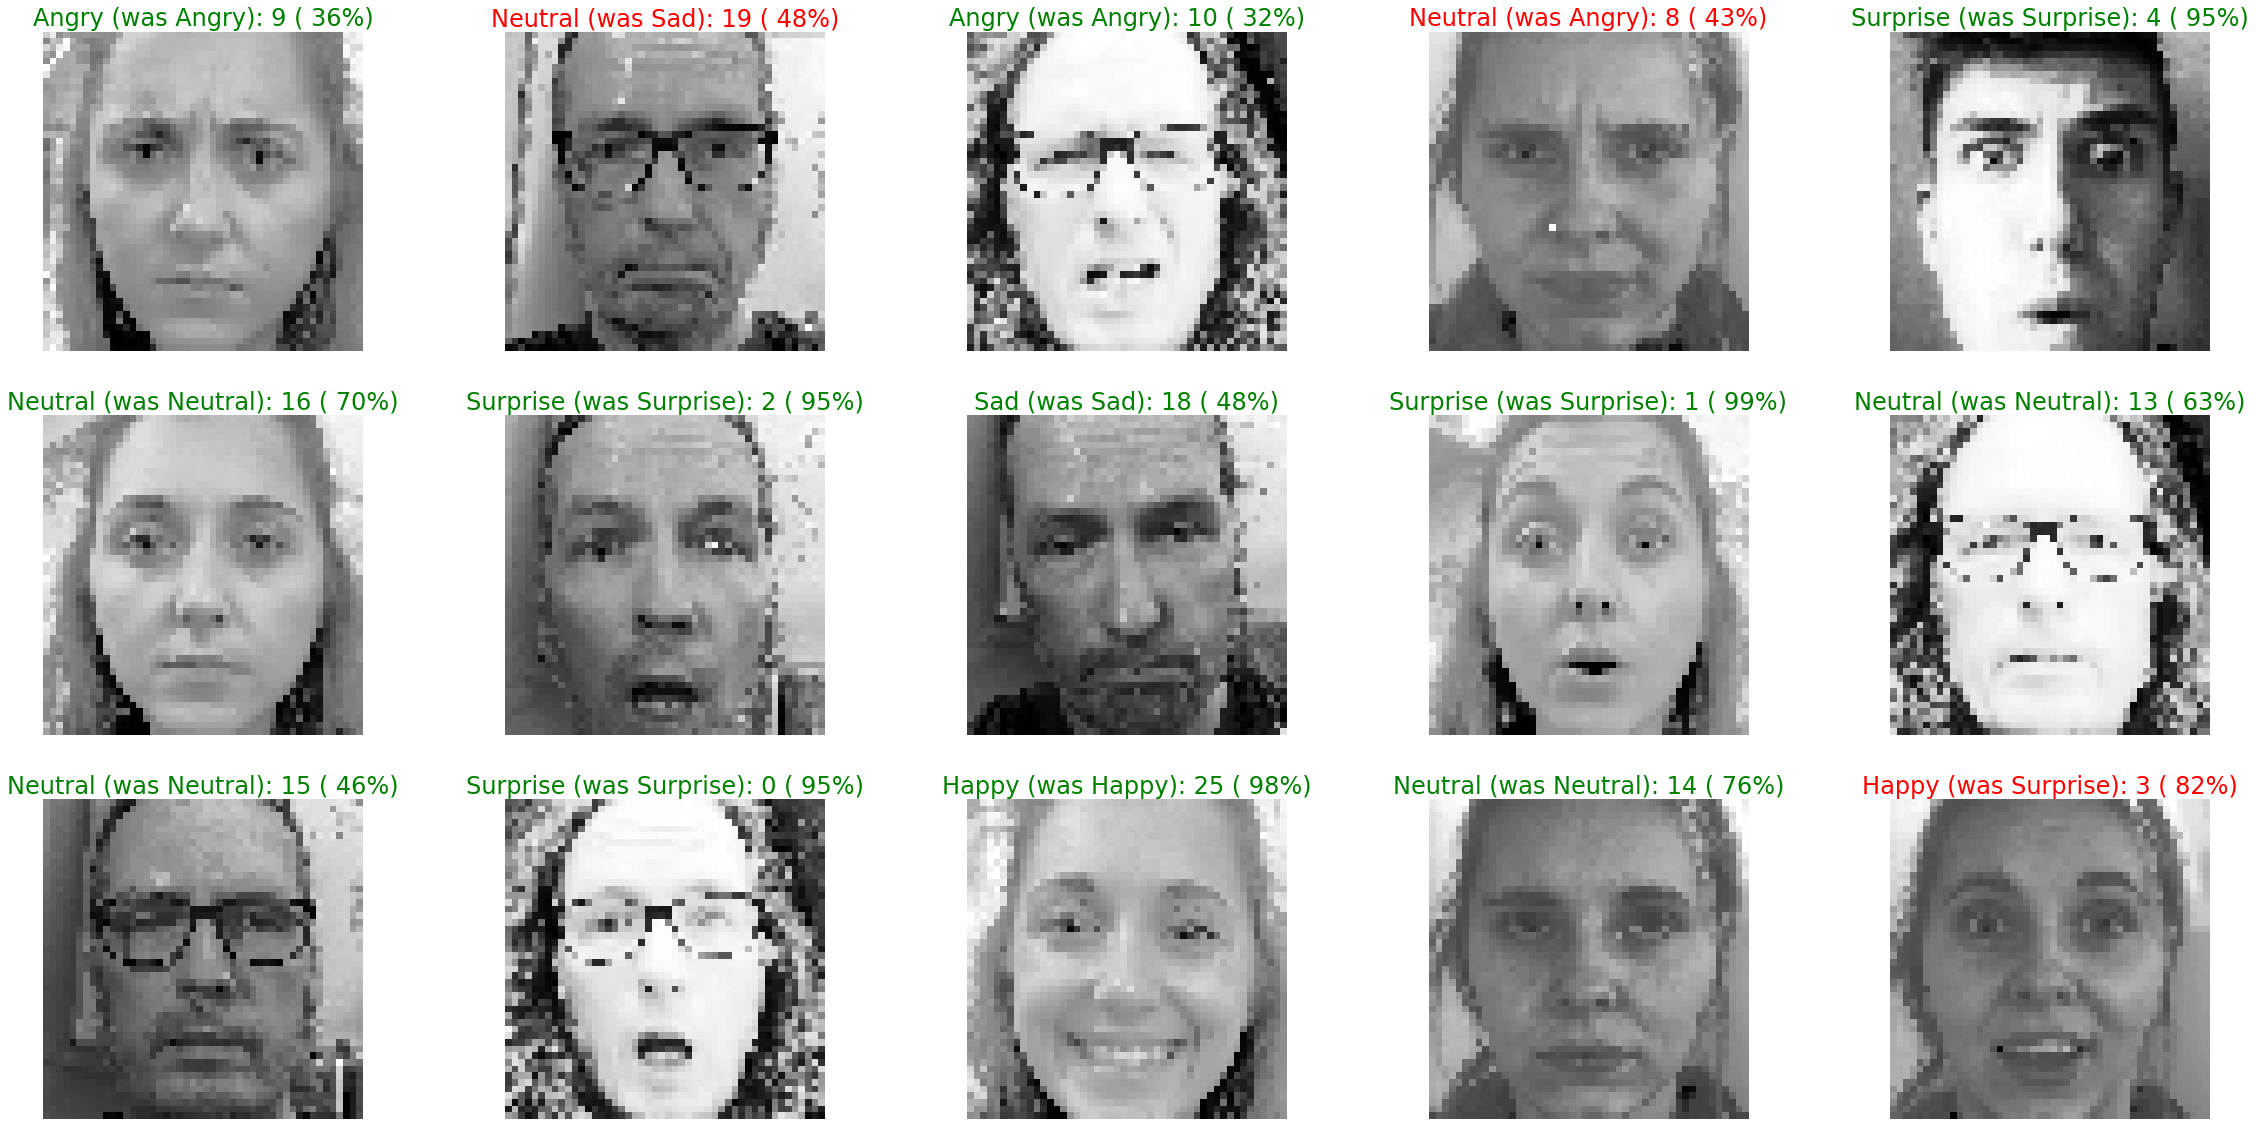

In [121]:
plot_gallery(model, X_real_world, y_real_world, filtered_label_names)

### Wrong

In [122]:
wrong_indices = np.where(y_real_world_pred != y_real_world)[0]
wrong_indices

array([ 3,  7,  8, 17, 19, 20, 21, 22, 24, 28])

(0.8217421, 0.31414112, 0.5118519)

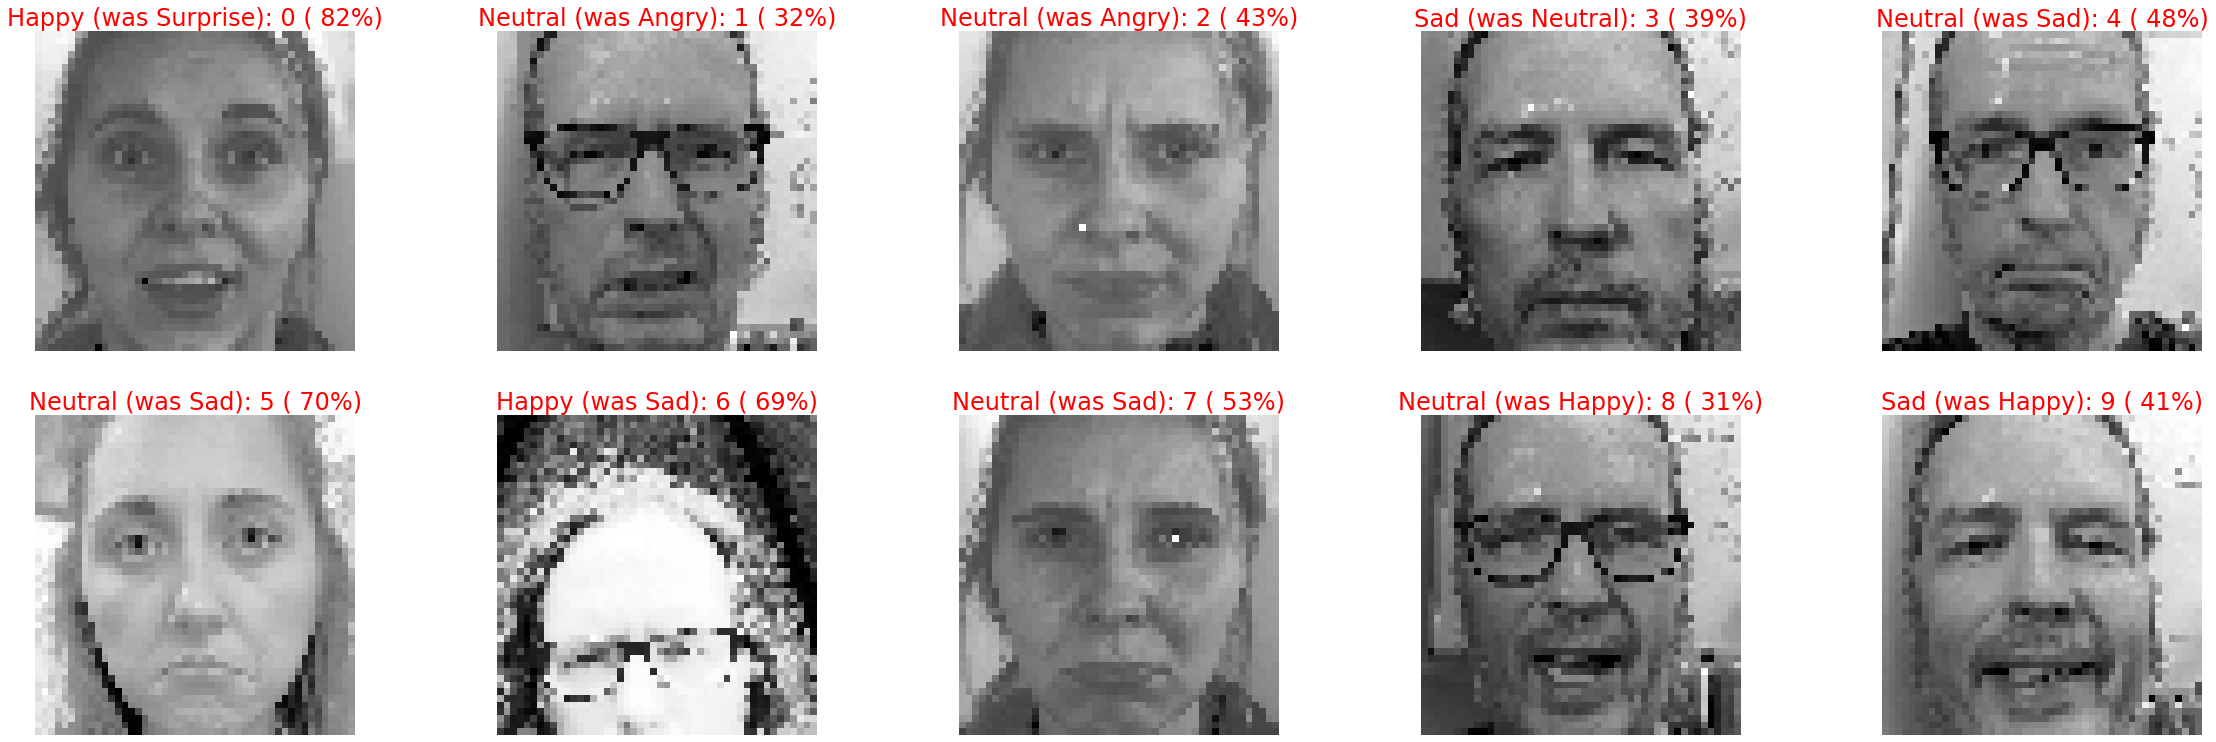

In [123]:
plot_gallery(model, X_real_world[wrong_indices], y_real_world[wrong_indices], filtered_label_names)

### Low Certainty

In [124]:
certainty = y_real_world_pred_raw.max(axis=1)
certainty

array([0.9515485 , 0.9935822 , 0.95524675, 0.8217421 , 0.9524996 ,
       0.9477438 , 0.7190288 , 0.32468498, 0.43184823, 0.36897555,
       0.3252645 , 0.4359452 , 0.64355826, 0.63452566, 0.76737607,
       0.4657865 , 0.70614624, 0.3988272 , 0.48298994, 0.48817518,
       0.7042722 , 0.6945508 , 0.53002805, 0.37810695, 0.31414115,
       0.9804606 , 0.99529415, 0.6006875 , 0.41024894, 0.96589756],
      dtype=float32)

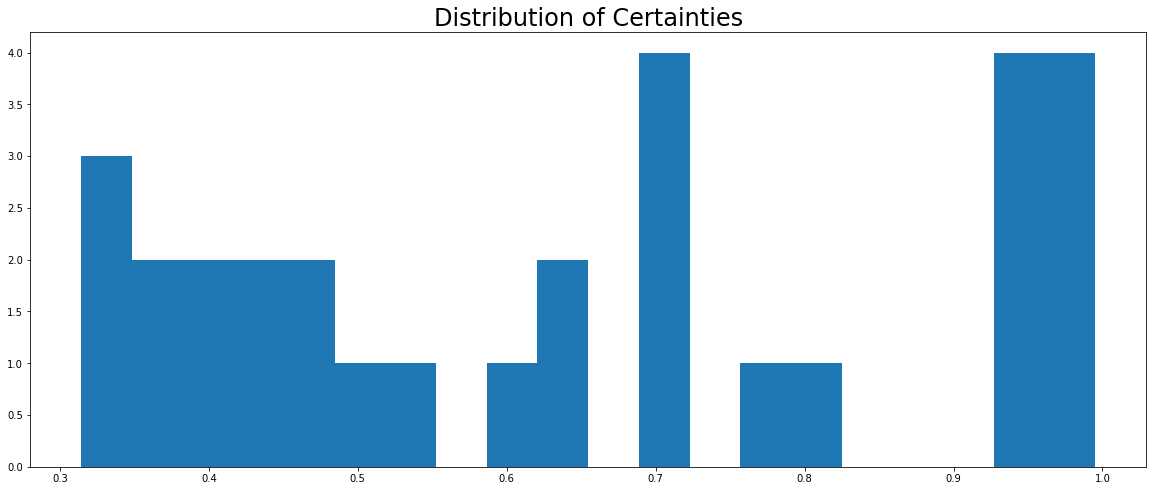

In [125]:
plt.title('Distribution of Certainties')
plt.hist(certainty, bins=20);

In [126]:
threshold = 0.7
# threshold = 0.9

In [127]:
low_certainty_indices = np.where(certainty < threshold)[0]
low_certainty_indices

array([ 7,  8,  9, 10, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23, 24, 27, 28])

(0.6945512, 0.31414142, 0.46637323)

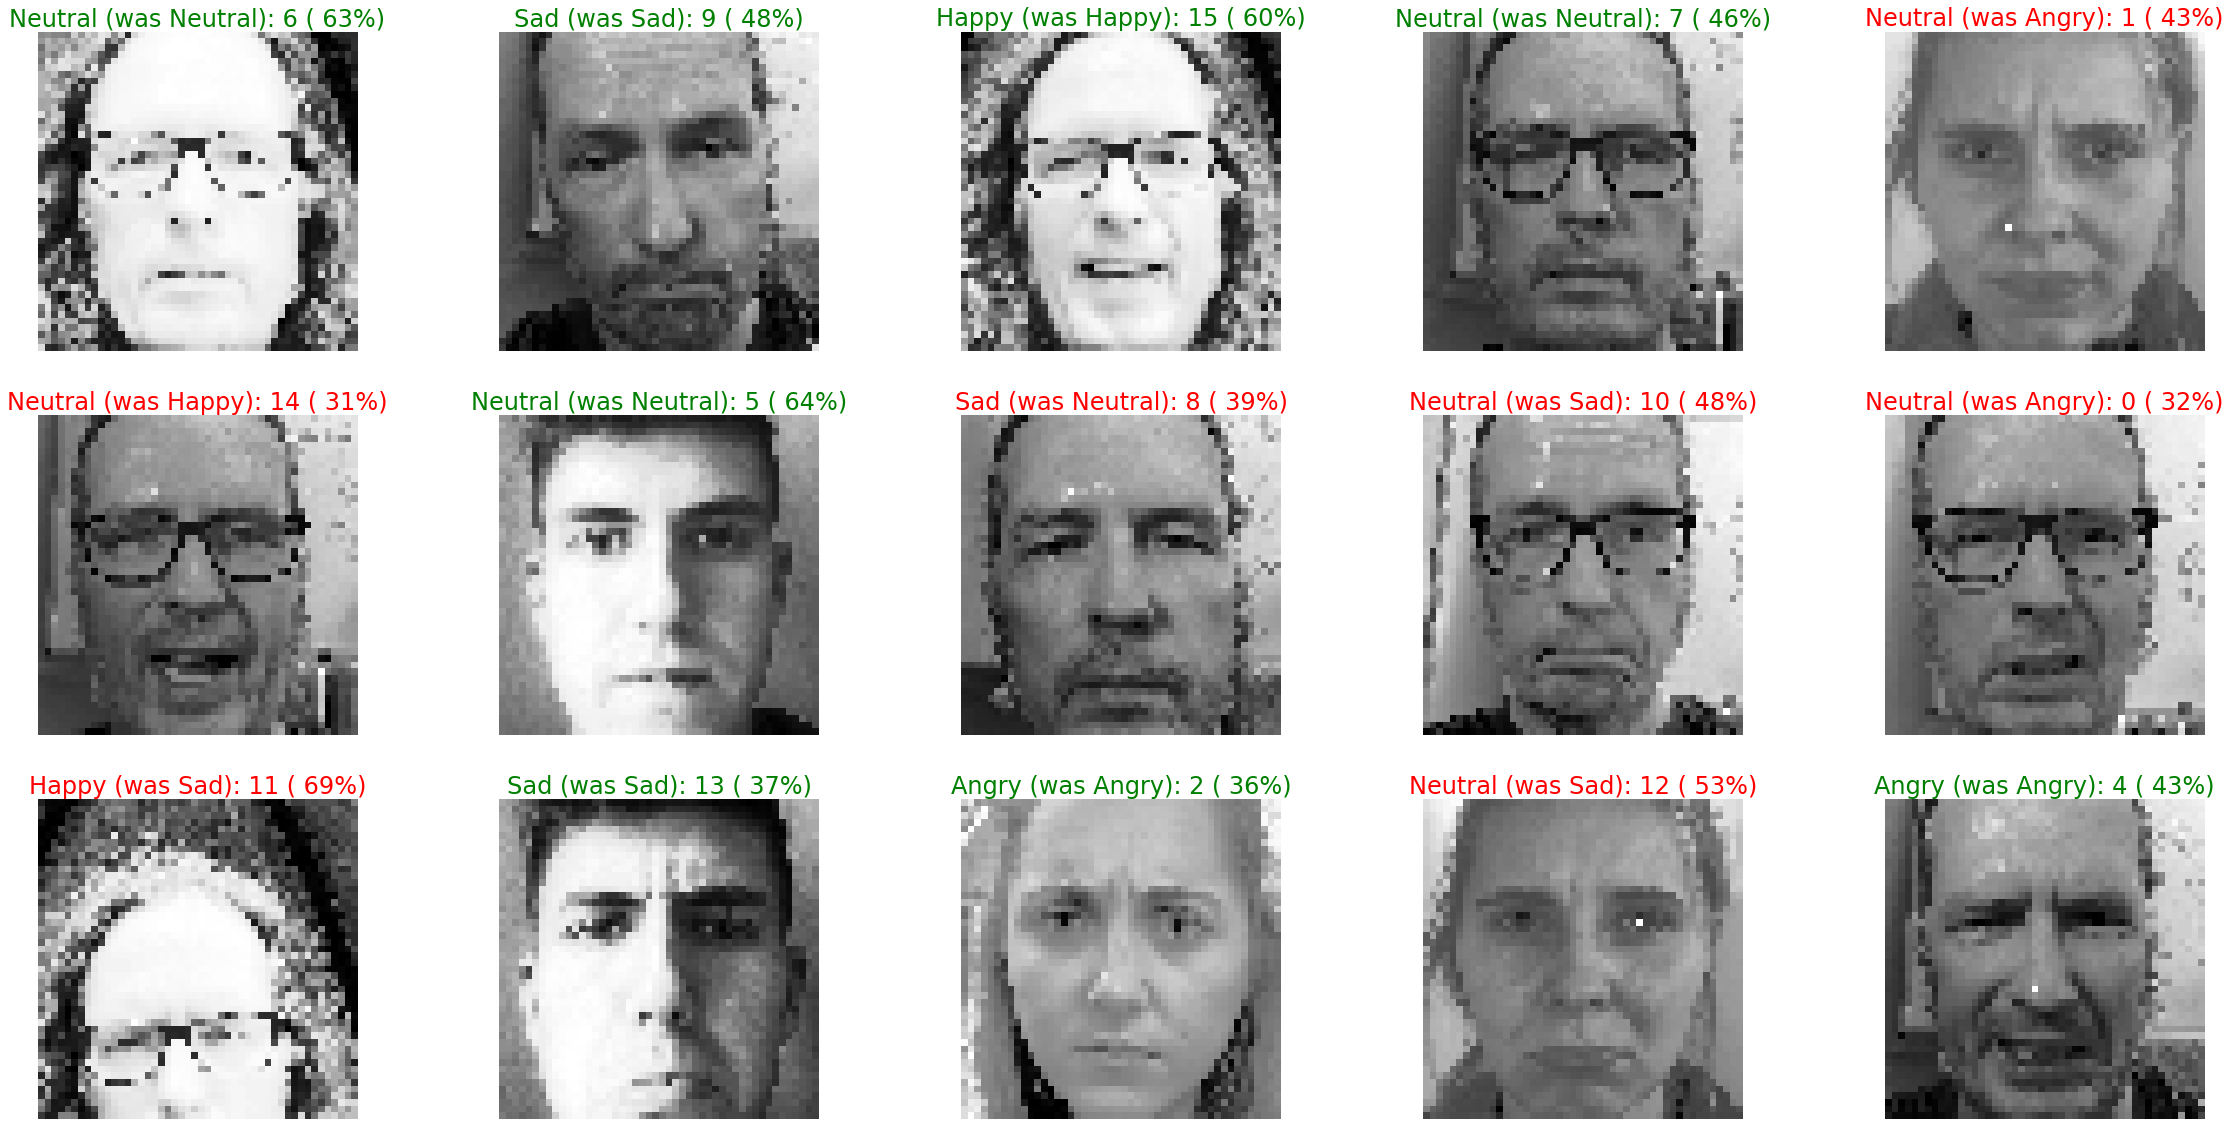

In [128]:
plot_gallery(model, X_real_world[low_certainty_indices], y_real_world[low_certainty_indices], filtered_label_names)

### High Certainty

In [129]:
# threshold = 0.80
threshold = 0.90

In [130]:
high_certainty_indices = np.where(certainty > threshold)[0]
high_certainty_indices

array([ 0,  1,  2,  4,  5, 25, 26, 29])

(0.99529415, 0.9477439, 0.96778417)

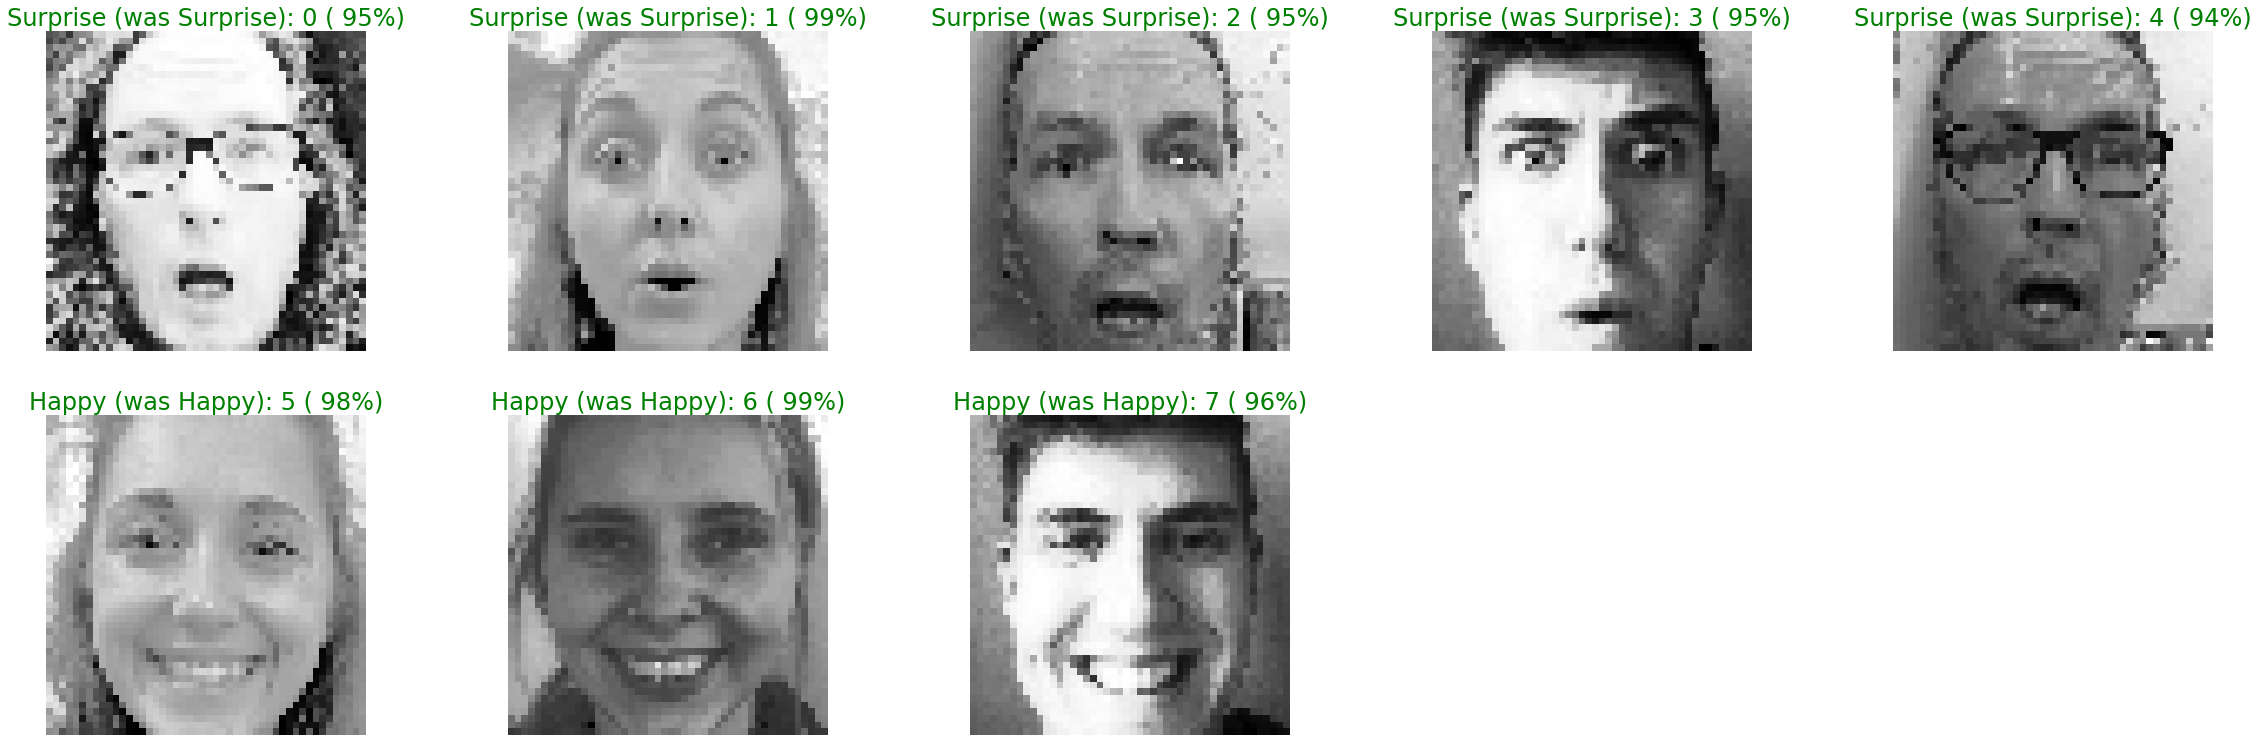

In [131]:
plot_gallery(model, X_real_world[high_certainty_indices], y_real_world[high_certainty_indices], filtered_label_names)

# Part IV: fine tune model on real world data (optional) (Olli)

* add one (few) iterations on real world data
  * would be much more promising if we have at least a few hundred samples
* most likely resnet works better for that as it has more capacity and no means of preventing overfitting on our small data set
* obvious risk: we overfit on the real world data and don't even notice
* mediocre solution: even split real world data into train and test
* could be interpreted as a form of curriculum learning
  * train with easy examples first
  * then continue with harder, more realistic ones
* alternative use case (having same approach): fine tune to a single user using some form of one-shot learning  


In [132]:
# you can load a predefined model

# !wget -c https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/resent50.h5
# !wget -c https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/simple-vgg.h5

In [133]:
import tensorflow as tf
# model = tf.keras.models.load_model('simple-vgg.h5')
model = tf.keras.models.load_model('resent50.h5')

In [134]:
# before training
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, verbose=0)
real_world_accuracy

0.6000000238418579

In [135]:
# due to a lack of good validation data we check on the original data set
_, accuracy = model.evaluate(X, y, verbose=0)
accuracy

0.8915252089500427

In [136]:
from sklearn.model_selection import train_test_split
X_real_world_train, X_real_world_test, y_real_world_train, y_real_world_test = train_test_split(X_real_world, y_real_world, test_size=0.2, random_state=21, stratify=y_real_world)
X_real_world_train.shape, X_real_world_test.shape, y_real_world_train.shape, y_real_world_test.shape

((24, 48, 48, 1), (6, 48, 48, 1), (24,), (6,))

In [137]:
%%time

from lrcurve import KerasLearningCurve

BATCH_SIZE = 50
EPOCHS = 10

# lr = 0.01 # default
lr = 0.001 # low

# optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_real_world_train, y_real_world_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    validation_data=(X_real_world_test, y_real_world_test),
                    callbacks=[KerasLearningCurve()],
                    verbose=0
                    )

CPU times: user 11.4 s, sys: 140 ms, total: 11.6 s
Wall time: 20.2 s


In [138]:
# after training
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, batch_size=BATCH_SIZE, verbose=0)
real_world_accuracy

0.800000011920929

In [139]:
# due to a lack of good validation data we check on the original data set
_, accuracy = model.evaluate(X, y, verbose=0)
accuracy

0.7874516248703003

1/1 [==============================] - 1s 818ms/step


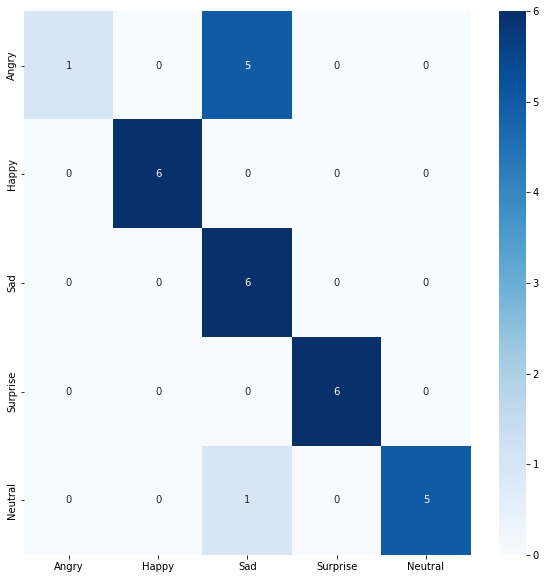

In [140]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names);

# Excursion: from Transformers to DALL-E (optional)


## Image recognition can be done with a transformer (encoder)

<img src='https://djcordhose.github.io/ml-resources/img/transformers/vit.jpg'>

https://arxiv.org/abs/2010.11929
<br>
https://huggingface.co/transformers/model_doc/vit.html

### Transformers

* Class of very large language models
* Trained for generality
* Mostly huge training data
* Require (currently) too much compute to use them productively in a meaningful way
* Distilled models and more compute pave the way to the productive world 
* Attention Layer is the most important component


### Transformer Architecture: Encoder/Decoder

<img src='https://djcordhose.github.io/ml-resources/img/transformers/transformer-encoder-decoder.png'>

* Left: Encoder
* Right: Decoder
* Encoder converts input to context-sensitive embeddings
* Decoder can operate on these embeddings, but always needs a left * context to generate the output
* Encoder and decoder can work together or each as standalone

https://arxiv.org/pdf/1706.03762.pdf


### Transformers need a different approach

* need more data to train
* you rather fine tune a pre-trained model
* much harder for images than for text, because of the vast amount of data
* MobileViT does not achieve results close to traditional CNNs when trained with the same effort


## Diffusion Models / DALLE-E 2

<img src="https://djcordhose.github.io/ml-resources/data/squirrels/2022/DALL-E-squirrels.png">

https://labs.openai.com/

### Diffusion Models

_DALL·E 2 has learned the relationship between images and the text used to describe them. It uses a process called “diffusion,” which starts with a pattern of random dots and gradually alters that pattern towards an image when it recognizes specific aspects of that image._

https://openai.com/dall-e-2/

### DALL·E 2 ist closed source 

only accessible over OpenAI API, but

* Stable Diffusion is free
  * https://stability.ai/blog/stable-diffusion-public-release
  * https://github.com/CompVis/stable-diffusion
* also available over KerasCV
  * https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/
  * https://twitter.com/fchollet/status/1574782176633430017
